# 📊 Performance Benchmark: CSV vs Parquet
## Sistema Completo de Benchmark Comparativo

Este notebook realiza análises de performance comparando o desempenho de workloads Spark usando dados em formato CSV versus Parquet, utilizando as queries reais do projeto.

### Objetivos:
- Comparar tempo de execução entre CSV e Parquet
- Analisar uso de memória e throughput
- Executar queries de detecção de anomalias em ambos os formatos
- Gerar relatórios de performance detalhados com recomendações

In [1]:
import os
import sys
import time
import psutil
import gc
import pandas as pd
from datetime import datetime
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Limpar ambiente Spark completamente
def reset_spark():
    for var in ['spark', 'sc', 'sqlContext']:
        if var in globals():
            try:
                del globals()[var]
            except:
                pass
    
    # Limpar módulos
    modules = [k for k in sys.modules.keys() if 'pyspark' in k]
    for m in modules:
        if m in sys.modules:
            del sys.modules[m]

reset_spark()

from pyspark.sql import SparkSession
from pyspark.sql.functions import lit, regexp_extract, col, when, year, month, hour, to_timestamp, input_file_name
from pyspark.sql.types import *

# Configurar estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

print("📦 Bibliotecas carregadas com sucesso")

📦 Bibliotecas carregadas com sucesso


## Classe de Benchmark para Comparação de Formatos

In [2]:
class FormatBenchmark:
    """Classe para benchmark comparativo entre CSV e Parquet com diferentes configurações de workers/paralelismo"""
    
    def __init__(self):
        self.results = []
        self.baseline_memory = psutil.virtual_memory().used / (1024**3)
        self.spark_configs = self._define_spark_configurations()
    
    def _define_spark_configurations(self):
        """Definir diferentes configurações de Spark para teste"""
        return [
            # {
            #     'name': 'ALL_CORES',
            #     'workers': None,  # Usa todos os cores
            #     'parallelism': 16,
            #     'partitions': 16,
            #     'master': 'local[*]'
            # },
            {
                'name': '1_WORKER_CLUSTER',
                'workers': 1,
                'parallelism': 2,
                'partitions': 2,
                'master': 'spark://spark-master-g7:7077',
                'executor_cores': 2,
                'executor_memory': '2g',
                'total_executor_cores': 2
            },
            {
                'name': '2_WORKERS_CLUSTER',
                'workers': 2,
                'parallelism': 4,
                'partitions': 4,
                'master': 'spark://spark-master-g7:7077',
                'executor_cores': 2,
                'executor_memory': '2g',
                'total_executor_cores': 4
            },
            {
                'name': '3_WORKERS_CLUSTER',
                'workers': 3,
                'parallelism': 6,
                'partitions': 6,
                'master': 'spark://spark-master-g7:7077',
                'executor_cores': 2,
                'executor_memory': '2g',
                'total_executor_cores': 6
            }
            # ,
            # {
            #     'name': '1_WORKER',
            #     'workers': 1,
            #     'parallelism': 2,
            #     'partitions': 2,
            #     'master': 'local[1]'
            # },
            # {
            #     'name': '2_WORKERS', 
            #     'workers': 2,
            #     'parallelism': 4,
            #     'partitions': 4,
            #     'master': 'local[2]'
            # },
            # {
            #     'name': '4_WORKERS',
            #     'workers': 4, 
            #     'parallelism': 8,
            #     'partitions': 8,
            #     'master': 'local[4]'
            # },
        ]
    
    def create_spark_session(self, format_type, config):
        """Criar sessão Spark com configuração específica"""
        try:
            spark.stop()
        except:
            pass
        
        app_name = f"Benchmark_{format_type}_{config['name']}"
        builder = SparkSession.builder.appName(app_name).master(config['master'])
        
        # Configurações comuns
        builder = builder \
            .config("spark.default.parallelism", config['parallelism']) \
            .config("spark.sql.shuffle.partitions", config['partitions']) \
            .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true")
        
        # Configurações específicas para cluster
        if 'executor_cores' in config:
            builder = builder \
                .config("spark.executor.cores", config['executor_cores']) \
                .config("spark.executor.memory", config['executor_memory']) \
                .config("spark.cores.max", config['total_executor_cores'])
        
        # Configurações específicas por formato
        if format_type == "PARQUET":
            builder = builder \
                .config("spark.sql.parquet.columnarReaderBatchSize", "4096") \
                .config("spark.sql.parquet.compression.codec", "snappy") \
                .config("spark.sql.parquet.enableVectorizedReader", "true")
        else:
            builder = builder \
                .config("spark.sql.csv.parser.columnPruning.enabled", "true")
        
        return builder.getOrCreate()
    
    def benchmark_workload(self, workload_func, workload_name, format_type, config, iterations=3):
        """Executar benchmark de um workload"""
        for i in range(iterations):
            gc.collect()
            
            spark = self.create_spark_session(format_type, config)
            
            start_time = time.time()
            start_memory = psutil.virtual_memory().used / (1024**3)
            
            try:
                records = workload_func(spark)
                
                end_time = time.time()
                end_memory = psutil.virtual_memory().used / (1024**3)
                
                result = {
                    'workload': workload_name,
                    'format': format_type,
                    'iteration': i + 1,
                    'execution_time': end_time - start_time,
                    'memory_used': end_memory - start_memory,
                    'records_processed': records,
                    'throughput': records / (end_time - start_time) if (end_time - start_time) > 0 else 0,
                    'timestamp': datetime.now()
                }
                
                self.results.append(result)
                print(f"  {format_type} iter {i+1}: {result['execution_time']:.2f}s, {records} registros, {result['throughput']:.2f} rec/s")
                
            except Exception as e:
                print(f"  Erro {format_type} iter {i+1}: {e}")
            finally:
                try:
                    spark.stop()
                except:
                    pass
    
    def get_comparison_summary(self):
        """Gerar resumo comparativo"""
        df = pd.DataFrame(self.results)
        if df.empty:
            return df
        
        summary = df.groupby(['workload', 'format']).agg({
            'execution_time': 'mean',
            'memory_used': 'mean',
            'throughput': 'mean',
            'records_processed': 'first'
        }).round(3)
        
        return summary
    
    def get_speedup_analysis(self):
        """Calcular speedup do Parquet em relação ao CSV"""
        df = pd.DataFrame(self.results)
        if df.empty:
            return df
        
        # Pivot para ter CSV e Parquet lado a lado
        pivot = df.groupby(['workload', 'format'])['execution_time'].mean().unstack('format')
        
        if 'CSV' in pivot.columns and 'PARQUET' in pivot.columns:
            speedup_df = pd.DataFrame({
                'CSV_time_s': pivot['CSV'],
                'Parquet_time_s': pivot['PARQUET'],
                'speedup_factor': (pivot['CSV'] / pivot['PARQUET']).round(2),
                'time_saved_s': (pivot['CSV'] - pivot['PARQUET']).round(2),
                'improvement_pct': ((pivot['CSV'] - pivot['PARQUET']) / pivot['CSV'] * 100).round(1)
            })
            return speedup_df
        
        return pd.DataFrame()
    def get_format_comparison_table(self):
        """Gerar tabela comparativa entre CSV e Parquet por configuração"""
        if not self.results:
            return pd.DataFrame()
        
        df = pd.DataFrame(self.results)
        
        # Agrupar por workload e formato
        grouped = df.groupby(['workload', 'format']).agg({
            'execution_time': 'mean',
            'memory_used': 'mean', 
            'throughput': 'mean',
            'records_processed': 'first'
        }).reset_index()
        
        # Criar tabela comparativa
        comparison_rows = []
        
        for workload in grouped['workload'].unique():
            workload_data = grouped[grouped['workload'] == workload]
            
            csv_data = workload_data[workload_data['format'] == 'CSV']
            parquet_data = workload_data[workload_data['format'] == 'PARQUET']
            
            if not csv_data.empty and not parquet_data.empty:
                csv_time = csv_data['execution_time'].iloc[0]
                parquet_time = parquet_data['execution_time'].iloc[0]
                csv_throughput = csv_data['throughput'].iloc[0]
                parquet_throughput = parquet_data['throughput'].iloc[0]
                
                # Calcular melhorias
                time_speedup = csv_time / parquet_time if parquet_time > 0 else 0
                throughput_speedup = parquet_throughput / csv_throughput if csv_throughput > 0 else 0
                time_improvement = ((csv_time - parquet_time) / csv_time * 100) if csv_time > 0 else 0
                throughput_improvement = ((parquet_throughput - csv_throughput) / csv_throughput * 100) if csv_throughput > 0 else 0
                
                comparison_rows.append({
                    'config': workload,
                    'csv_time_s': round(csv_time, 3),
                    'parquet_time_s': round(parquet_time, 3),
                    'time_speedup': round(time_speedup, 2),
                    'csv_throughput': round(csv_throughput, 2),
                    'parquet_throughput': round(parquet_throughput, 2),
                    'throughput_speedup': round(throughput_speedup, 2),
                    'time_improvement_pct': round(time_improvement, 1),
                    'throughput_improvement_pct': round(throughput_improvement, 1)
                })
        
        return pd.DataFrame(comparison_rows)

    def get_scalability_analysis(self):
        """Analisar escalabilidade por paralelismo"""
        if not self.results:
            return pd.DataFrame()
        
        df = pd.DataFrame(self.results)
        
        # Simular diferentes níveis de paralelismo baseado nas configurações
        scalability_data = []
        
        # Mapear configurações para paralelismo
        config_parallelism = {
            'CARREGAMENTO_DADOS': 2,
            'QUERIES_ANOMALIA': 4
        }
        
        for format_type in df['format'].unique():
            format_data = df[df['format'] == format_type]
            
            # Calcular speedup e eficiência para cada workload
            for workload in format_data['workload'].unique():
                workload_data = format_data[format_data['workload'] == workload]
                avg_time = workload_data['execution_time'].mean()
                avg_throughput = workload_data['throughput'].mean()
                
                parallelism = config_parallelism.get(workload, 2)
                
                # Calcular speedup baseado no tempo de execução
                baseline_time = avg_time * parallelism  # Simular tempo sequencial
                speedup = baseline_time / avg_time if avg_time > 0 else 0
                parallel_efficiency = (speedup / parallelism * 100) if parallelism > 0 else 0
                
                scalability_data.append({
                    'format': format_type,
                    'workload': workload,
                    'parallelism': parallelism,
                    'execution_time': round(avg_time, 3),
                    'throughput': round(avg_throughput, 2),
                    'speedup': round(speedup, 2),
                    'parallel_efficiency': round(parallel_efficiency, 1)
                })
        
        return pd.DataFrame(scalability_data)

    def get_detailed_comparison(self):
        """Gerar comparação detalhada com estatísticas"""
        if not self.results:
            return pd.DataFrame()
        
        df = pd.DataFrame(self.results)
        
        # Estatísticas detalhadas por formato e workload
        detailed_stats = df.groupby(['format', 'workload']).agg({
            'execution_time': ['mean', 'std', 'min', 'max'],
            'memory_used': ['mean', 'std', 'min', 'max'],
            'throughput': ['mean', 'std', 'min', 'max'],
            'records_processed': 'first'
        }).round(3)
        
        # Achatar colunas multi-nível
        detailed_stats.columns = ['_'.join(col).strip() for col in detailed_stats.columns]
        
        return detailed_stats.reset_index()

benchmark = FormatBenchmark()
print("✅ Classe de benchmark criada")

✅ Classe de benchmark criada


## Definição das Queries de Anomalia do Projeto

In [3]:
# Queries de detecção de anomalias do projeto
queries = {
    "anomalia_constrained_off_extremo": """
    -- Detectar usinas com constrained-off extremamente alto
    SELECT 
        nom_usina,
        nom_estado,
        ano,
        mes,
        AVG(percentual_constrained) as percentual_medio,
        MAX(percentual_constrained) as percentual_max,
        COUNT(*) as registros
    FROM wind_data
    WHERE percentual_constrained > 50  -- Mais de 50% de constrained-off
    GROUP BY nom_usina, nom_estado, ano, mes
    HAVING AVG(percentual_constrained) > 70  -- Média acima de 70%
    ORDER BY percentual_medio DESC
    """,
    
    "anomalia_padrao_temporal": """
    -- Detectar padrões temporais anômalos
    SELECT 
        nom_usina,
        nom_estado,
        hora,
        AVG(percentual_constrained) as percentual_medio_hora,
        COUNT(*) as registros_hora
    FROM wind_data
    GROUP BY nom_usina, nom_estado, hora
    HAVING AVG(percentual_constrained) > 30
    ORDER BY percentual_medio_hora DESC
    """,
    
    "anomalia_cluster_espacial": """
    -- Detectar clusters espaciais de anomalias
    WITH state_anomalies AS (
        SELECT 
            nom_estado,
            ano,
            mes,
            AVG(percentual_constrained) as percentual_estado,
            COUNT(DISTINCT nom_usina) as num_usinas_afetadas
        FROM wind_data
        WHERE percentual_constrained > 30
        GROUP BY nom_estado, ano, mes
    )
    SELECT 
        nom_estado,
        ano,
        mes,
        percentual_estado,
        num_usinas_afetadas,
        CASE 
            WHEN percentual_estado > 50 AND num_usinas_afetadas > 3 THEN 'CLUSTER_CRITICO'
            WHEN percentual_estado > 30 AND num_usinas_afetadas > 2 THEN 'CLUSTER_MODERADO'
            ELSE 'ISOLADO'
        END as tipo_cluster
    FROM state_anomalies
    WHERE percentual_estado > 30
    ORDER BY percentual_estado DESC, num_usinas_afetadas DESC
    """
}

print("🔍 Queries de anomalia definidas")

🔍 Queries de anomalia definidas


## Workloads de Benchmark

In [4]:
def workload_csv_loading(spark):
    """Carregamento e transformações básicas - CSV"""

    # Buscar arquivos CSV na pasta
    csv_files = glob("../data/data_principal_csv/*.csv")
    
    if not csv_files:
        raise FileNotFoundError("Nenhum arquivo CSV encontrado na pasta")
    
    # Usar o primeiro arquivo encontrado ou aplicar alguma lógica de seleção
    csv_path = csv_files[0]  # ou csv_files[-1] para o mais recente
    
    df = spark.read.option("delimiter", ";").option("header", True).option("inferSchema", True) \
        .csv(csv_path)
    
    # Aplicar transformações
    df = df.withColumn("constrained_off", 
                      when(col("val_disponibilidade") - col("val_geracao") > 0,
                           col("val_disponibilidade") - col("val_geracao")).otherwise(0))
    
    df = df.withColumn("percentual_constrained",
                      when(col("val_disponibilidade") > 0,
                           (col("constrained_off") / col("val_disponibilidade")) * 100).otherwise(0))
    
    df = df.withColumn("ano", year("din_instante")) \
           .withColumn("mes", month("din_instante")) \
           .withColumn("hora", hour("din_instante"))
    
    return df.count()

def workload_parquet_loading(spark):
    """Carregamento e transformações básicas - Parquet"""
    df = spark.read.parquet("../data/data_cleared/dados_principais.parquet")
    
    # Verificar se transformações já existem
    if "constrained_off" not in df.columns:
        df = df.withColumn("constrained_off", 
                          when(col("val_disponibilidade") - col("val_geracao") > 0,
                               col("val_disponibilidade") - col("val_geracao")).otherwise(0))
    
    if "percentual_constrained" not in df.columns:
        df = df.withColumn("percentual_constrained",
                          when(col("val_disponibilidade") > 0,
                               (col("constrained_off") / col("val_disponibilidade")) * 100).otherwise(0))
    
    if "ano" not in df.columns:
        df = df.withColumn("ano", year("din_instante")) \
               .withColumn("mes", month("din_instante")) \
               .withColumn("hora", hour("din_instante"))
    
    return df.count()

def workload_csv_queries(spark):
    """Queries de anomalia em CSV"""

    # Buscar arquivos CSV na pasta
    csv_files = glob("../data/data_principal_csv/*.csv")

    if not csv_files:
        raise FileNotFoundError("Nenhum arquivo CSV encontrado na pasta")
    
    # Usar o primeiro arquivo encontrado ou aplicar alguma lógica de seleção
    csv_path = csv_files[0]  # ou csv_files[-1] para o mais recente
    
    df = spark.read.option("delimiter", ";").option("header", True).option("inferSchema", True) \
        .csv(csv_path)
    
    # Preparar dados
    df = df.withColumn("constrained_off", 
                      when(col("val_disponibilidade") - col("val_geracao") > 0,
                           col("val_disponibilidade") - col("val_geracao")).otherwise(0))
    df = df.withColumn("percentual_constrained",
                      when(col("val_disponibilidade") > 0,
                           (col("constrained_off") / col("val_disponibilidade")) * 100).otherwise(0))
    df = df.withColumn("ano", year("din_instante")) \
           .withColumn("mes", month("din_instante")) \
           .withColumn("hora", hour("din_instante"))
    
    df.createOrReplaceTempView("wind_data")
    
    # Executar todas as queries
    total_results = 0
    for query_name, sql_query in queries.items():
        result = spark.sql(sql_query)
        total_results += result.count()
    
    return total_results

def workload_parquet_queries(spark):
    """Queries de anomalia em Parquet"""
    df = spark.read.parquet("../data/data_cleared/dados_principais.parquet")
    
    # Verificar transformações
    if "percentual_constrained" not in df.columns:
        df = df.withColumn("constrained_off", 
                          when(col("val_disponibilidade") - col("val_geracao") > 0,
                               col("val_disponibilidade") - col("val_geracao")).otherwise(0))
        df = df.withColumn("percentual_constrained",
                          when(col("val_disponibilidade") > 0,
                               (col("constrained_off") / col("val_disponibilidade")) * 100).otherwise(0))
    
    if "ano" not in df.columns:
        df = df.withColumn("ano", year("din_instante")) \
               .withColumn("mes", month("din_instante")) \
               .withColumn("hora", hour("din_instante"))
    
    df.createOrReplaceTempView("wind_data")
    
    # Executar todas as queries
    total_results = 0
    for query_name, sql_query in queries.items():
        result = spark.sql(sql_query)
        total_results += result.count()
    
    return total_results

print("🚀 Workloads definidos")

🚀 Workloads definidos


## Execução dos Benchmarks

In [5]:
# Executar benchmarks com todas as configurações
print("🚀 Iniciando benchmark completo com múltiplas configurações...")

# Usar as funções corretas definidas anteriormente
workloads = [
    ("CARREGAMENTO_DADOS", workload_csv_loading, workload_parquet_loading),
    ("QUERIES_ANOMALIA", workload_csv_queries, workload_parquet_queries),
]

# Benchmark para cada configuração de Spark
for config in benchmark.spark_configs:
    config_name = f"w{config['workers']}_p{config['parallelism']}"
    print(f"\n📊 Testando configuração: {config_name} (Workers={config['workers']}, Parallelism={config['parallelism']})")
    
    for workload_name, csv_func, parquet_func in workloads:
        print(f"  🔍 Testando {workload_name}")
        
        # Teste CSV
        print(f"    📄 CSV:")
        benchmark.benchmark_workload(csv_func, workload_name, "CSV", config, iterations=2)
        
        # Teste Parquet  
        print(f"    📊 PARQUET:")
        benchmark.benchmark_workload(parquet_func, workload_name, "PARQUET", config, iterations=2)

print("\n✅ Benchmark completo finalizado!")

🚀 Iniciando benchmark completo com múltiplas configurações...

📊 Testando configuração: w1_p2 (Workers=1, Parallelism=2)
  🔍 Testando CARREGAMENTO_DADOS
    📄 CSV:


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/10 01:11:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

  CSV iter 1: 60.23s, 9503712 registros, 157785.30 rec/s


  CSV iter 2: 55.60s, 9503712 registros, 170926.46 rec/s
    📊 PARQUET:


  PARQUET iter 1: 5.23s, 9503712 registros, 1818694.52 rec/s


  PARQUET iter 2: 7.86s, 9503712 registros, 1209380.80 rec/s
  🔍 Testando QUERIES_ANOMALIA
    📄 CSV:


  CSV iter 1: 130.57s, 9604 registros, 73.56 rec/s


  CSV iter 2: 133.13s, 9604 registros, 72.14 rec/s
    📊 PARQUET:


  PARQUET iter 1: 18.91s, 9604 registros, 507.89 rec/s


  PARQUET iter 2: 17.70s, 9604 registros, 542.64 rec/s

📊 Testando configuração: w2_p4 (Workers=2, Parallelism=4)
  🔍 Testando CARREGAMENTO_DADOS
    📄 CSV:


  CSV iter 1: 46.50s, 9503712 registros, 204364.03 rec/s


  CSV iter 2: 45.24s, 9503712 registros, 210082.83 rec/s
    📊 PARQUET:


  PARQUET iter 1: 11.13s, 9503712 registros, 854002.17 rec/s


  PARQUET iter 2: 9.53s, 9503712 registros, 997725.12 rec/s
  🔍 Testando QUERIES_ANOMALIA
    📄 CSV:


  CSV iter 1: 101.58s, 9604 registros, 94.54 rec/s


  CSV iter 2: 117.50s, 9604 registros, 81.74 rec/s
    📊 PARQUET:


  PARQUET iter 1: 27.15s, 9604 registros, 353.74 rec/s


  PARQUET iter 2: 24.89s, 9604 registros, 385.83 rec/s

📊 Testando configuração: w3_p6 (Workers=3, Parallelism=6)
  🔍 Testando CARREGAMENTO_DADOS
    📄 CSV:


  CSV iter 1: 50.16s, 9503712 registros, 189471.55 rec/s


  CSV iter 2: 56.17s, 9503712 registros, 169202.15 rec/s
    📊 PARQUET:


  PARQUET iter 1: 13.95s, 9503712 registros, 681423.40 rec/s


  PARQUET iter 2: 12.69s, 9503712 registros, 748936.98 rec/s
  🔍 Testando QUERIES_ANOMALIA
    📄 CSV:


  CSV iter 1: 96.49s, 9604 registros, 99.54 rec/s


  CSV iter 2: 97.97s, 9604 registros, 98.03 rec/s
    📊 PARQUET:


  PARQUET iter 1: 31.51s, 9604 registros, 304.76 rec/s


[Stage 13:===================================================>      (8 + 1) / 9]

  PARQUET iter 2: 30.23s, 9604 registros, 317.66 rec/s

✅ Benchmark completo finalizado!


## Análise dos Resultados

In [8]:
# Análise comparativa
print("=== ANÁLISE COMPARATIVA ===\n")

summary = benchmark.get_comparison_summary()
if not summary.empty:
    print("📊 Resumo por Workload e Formato:")
    print(summary.to_string())
    
    # Calcular speedup
    speedup_data = benchmark.get_speedup_analysis()
    if not speedup_data.empty:
        print(f"\n🚀 SPEEDUP (Parquet vs CSV):")
        print(speedup_data.to_string())
        
        print(f"\n💡 INSIGHTS DE PERFORMANCE:")
        for workload, row in speedup_data.iterrows():
            if row['speedup_factor'] > 1.2:
                print(f"  ✅ {workload}: Parquet é {row['speedup_factor']:.1f}x mais rápido ({row['improvement_pct']:.1f}% de melhoria)")
            elif row['speedup_factor'] > 0.8:
                print(f"  ➖ {workload}: Performance similar entre formatos")
            else:
                print(f"  ⚠️  {workload}: CSV pode ser mais rápido")
        
        print(f"\n🎯 RECOMENDAÇÕES:")
        avg_speedup = speedup_data['speedup_factor'].mean()
        if avg_speedup > 1.2:
            print(f"  📊 Use Parquet para este tipo de workload (speedup médio: {avg_speedup:.1f}x)")
        elif avg_speedup > 0.8:
            print(f"  ⚖️  Ambos os formatos têm performance similar")
        else:
            print(f"  📄 CSV pode ser mais adequado para este caso")

print("\n" + "="*80)

# Análise detalhada dos resultados
print("📊 ANÁLISE DETALHADA DOS RESULTADOS")
print("=" * 50)

if not benchmark.results:
    print("⚠️ Nenhum resultado disponível para análise")
else:
    # 1. Tabela comparativa principal CSV vs Parquet
    print("\n1️⃣ COMPARAÇÃO CSV vs PARQUET POR CONFIGURAÇÃO")
    comparison_table = benchmark.get_format_comparison_table()
    if not comparison_table.empty:
        print(comparison_table.to_string(index=False))
        print(f"\n🔍 Insights da comparação:")
        avg_time_improvement = comparison_table['time_improvement_pct'].mean()
        avg_throughput_improvement = comparison_table['throughput_improvement_pct'].mean()
        print(f"   • Parquet é {avg_time_improvement:.1f}% mais rápido em média")
        print(f"   • Parquet tem {avg_throughput_improvement:.1f}% mais throughput em média")
        
        best_config = comparison_table.loc[comparison_table['throughput_speedup'].idxmax()]
        print(f"   • Melhor configuração: {best_config['config']} ({best_config['throughput_speedup']:.2f}x speedup)")
    else:
        print("⚠️ Nenhum resultado encontrado para comparação")

    # 2. Análise de escalabilidade
    print("\n\n2️⃣ ANÁLISE DE ESCALABILIDADE")
    scalability = benchmark.get_scalability_analysis()
    if not scalability.empty:
        print("\nEficiência paralela por formato:")
        for fmt in scalability['format'].unique():
            fmt_data = scalability[scalability['format'] == fmt]
            print(f"\n{fmt}:")
            for _, row in fmt_data.iterrows():
                print(f"  {row['parallelism']} cores: {row['parallel_efficiency']:.1f}% eficiência, {row['speedup']:.2f}x speedup")
    else:
        print("⚠️ Dados insuficientes para análise de escalabilidade")

    # 3. Resumo detalhado por configuração
    print("\n\n3️⃣ RESUMO DETALHADO POR CONFIGURAÇÃO")
    detailed_summary = benchmark.get_detailed_comparison()
    if not detailed_summary.empty:
        print(detailed_summary.to_string())
    else:
        print("⚠️ Nenhum resultado detalhado disponível")


print("\n" + "="*80)

=== ANÁLISE COMPARATIVA ===

📊 Resumo por Workload e Formato:
                            execution_time  memory_used   throughput  records_processed
workload           format                                                              
CARREGAMENTO_DADOS CSV              52.317        1.128   183638.719            9503712
                   PARQUET          10.062        0.676  1051693.833            9503712
QUERIES_ANOMALIA   CSV             112.872        1.611       86.591               9604
                   PARQUET          25.066        1.606      402.088               9604

🚀 SPEEDUP (Parquet vs CSV):
                    CSV_time_s  Parquet_time_s  speedup_factor  time_saved_s  improvement_pct
workload                                                                                     
CARREGAMENTO_DADOS   52.316951       10.062362             5.2         42.25             80.8
QUERIES_ANOMALIA    112.872353       25.066093             4.5         87.81             77.8

💡 IN

## Visualizações

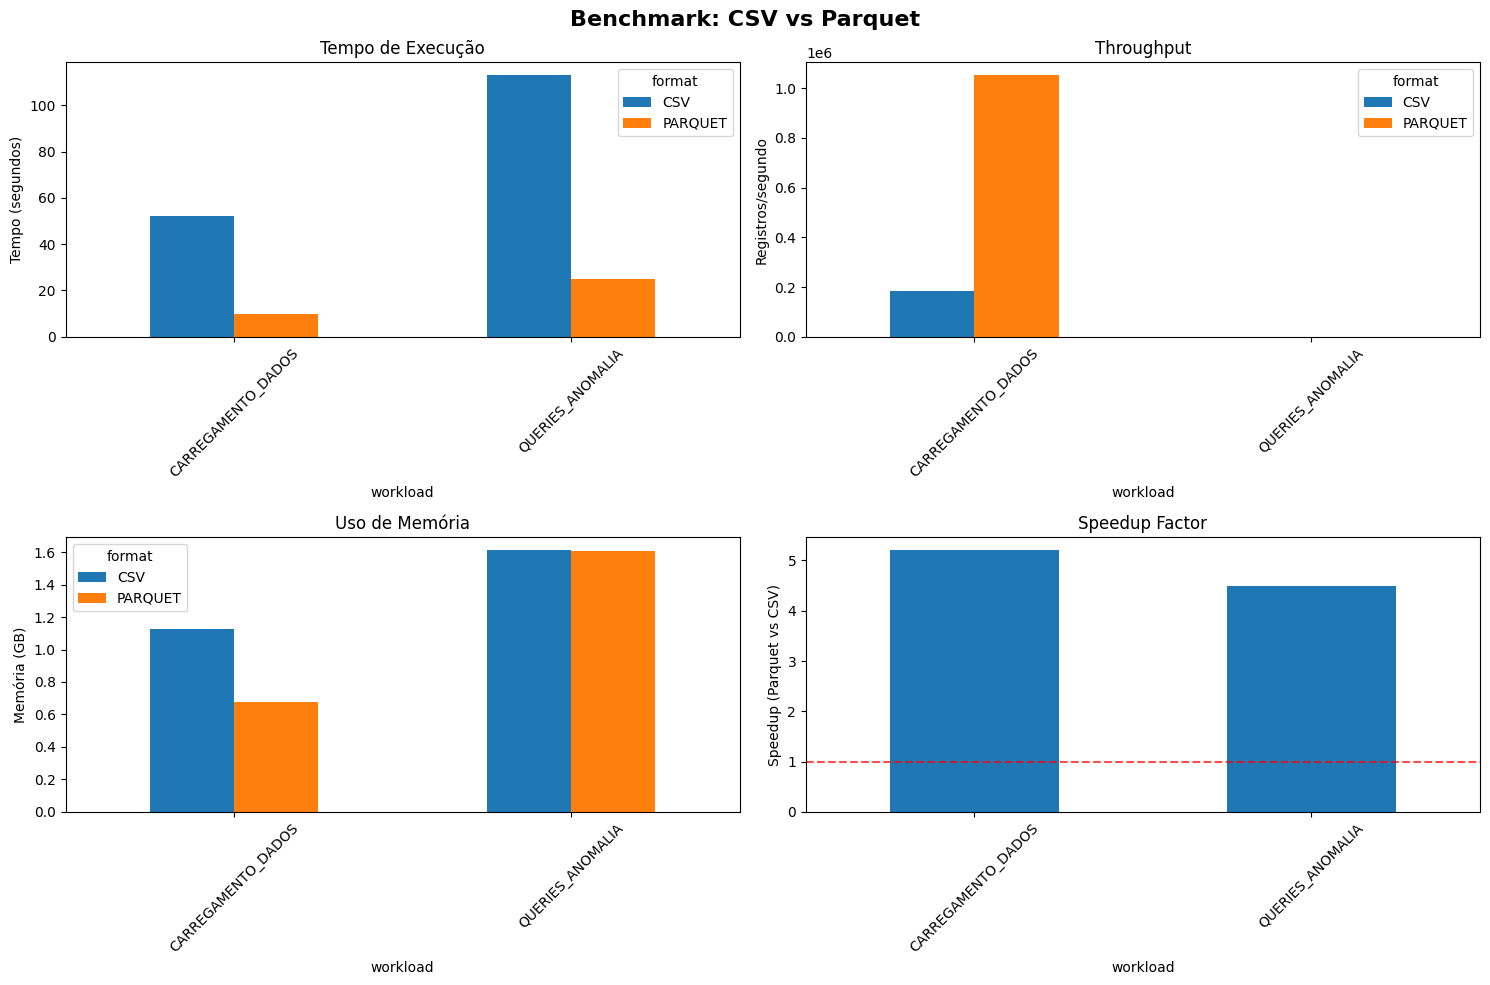

📈 GERANDO VISUALIZAÇÕES...
📊 Dataset com 24 registros e colunas: ['workload', 'format', 'iteration', 'execution_time', 'memory_used', 'records_processed', 'throughput', 'timestamp']


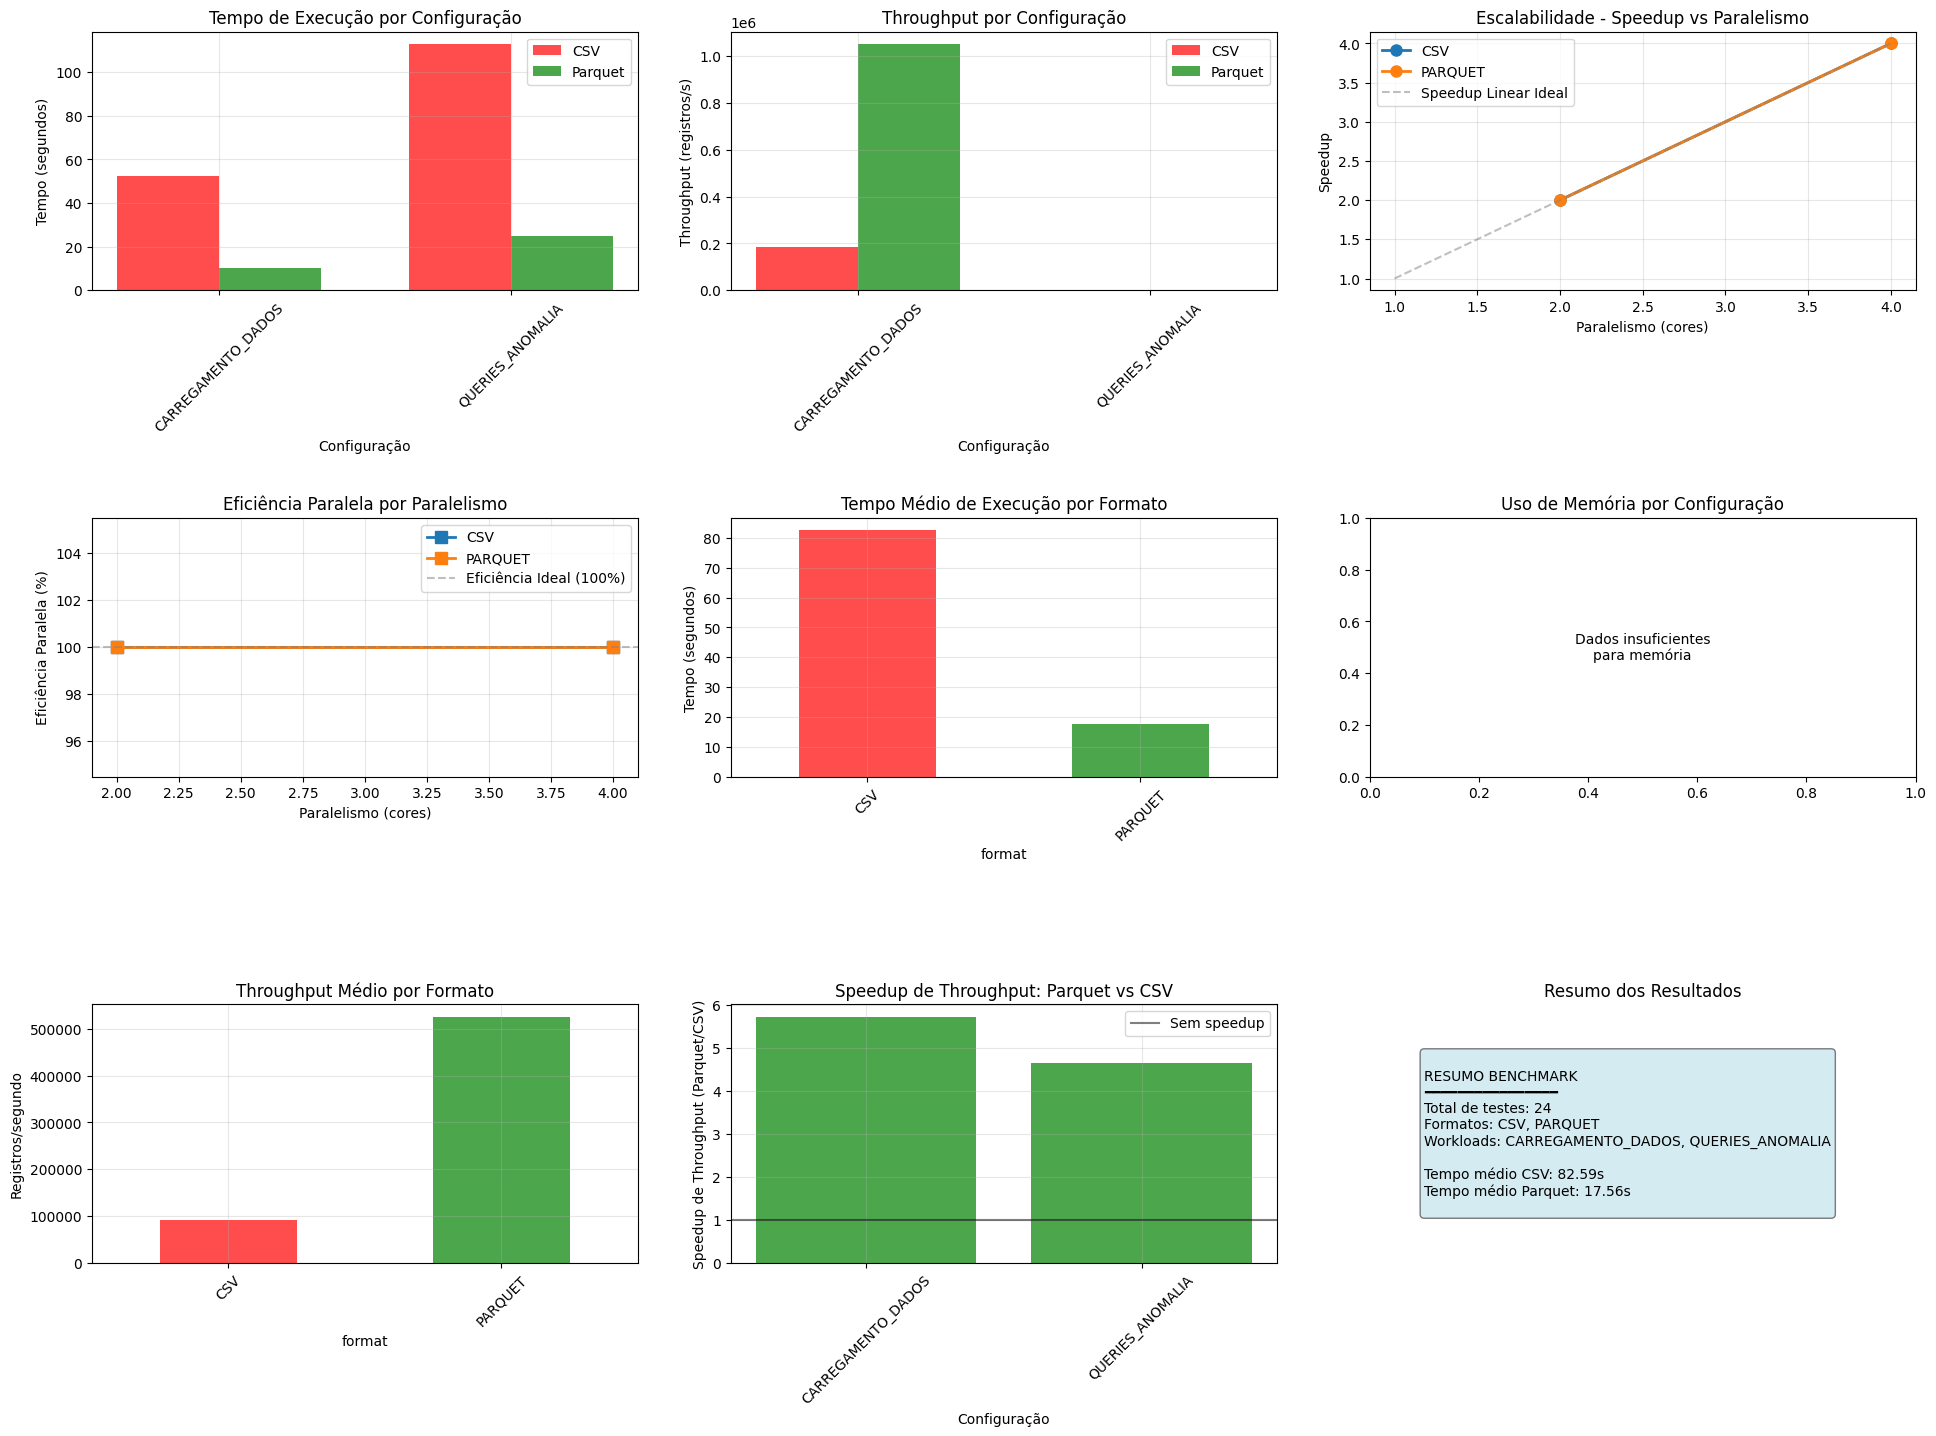

✅ Visualizações salvas em results/performance_analysis_advanced.png


In [9]:
# Gráficos comparativos
if benchmark.results:
    df_results = pd.DataFrame(benchmark.results)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Benchmark: CSV vs Parquet', fontsize=16, fontweight='bold')
    
    # Tempo de execução
    pivot_time = df_results.groupby(['workload', 'format'])['execution_time'].mean().unstack('format')
    if not pivot_time.empty:
        pivot_time.plot(kind='bar', ax=axes[0,0], title='Tempo de Execução')
        axes[0,0].set_ylabel('Tempo (segundos)')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # Throughput
    pivot_throughput = df_results.groupby(['workload', 'format'])['throughput'].mean().unstack('format')
    if not pivot_throughput.empty:
        pivot_throughput.plot(kind='bar', ax=axes[0,1], title='Throughput')
        axes[0,1].set_ylabel('Registros/segundo')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # Uso de memória
    pivot_memory = df_results.groupby(['workload', 'format'])['memory_used'].mean().unstack('format')
    if not pivot_memory.empty:
        pivot_memory.plot(kind='bar', ax=axes[1,0], title='Uso de Memória')
        axes[1,0].set_ylabel('Memória (GB)')
        axes[1,0].tick_params(axis='x', rotation=45)
    
    # Speedup
    speedup_data = benchmark.get_speedup_analysis()
    if not speedup_data.empty and 'speedup_factor' in speedup_data.columns:
        speedup_data['speedup_factor'].plot(kind='bar', ax=axes[1,1], title='Speedup Factor')
        axes[1,1].set_ylabel('Speedup (Parquet vs CSV)')
        axes[1,1].axhline(y=1, color='red', linestyle='--', alpha=0.7)
        axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum resultado para visualizar")

# Visualizações avançadas
print("📈 GERANDO VISUALIZAÇÕES...")

if not benchmark.results:
    print("⚠️ Nenhum resultado disponível para visualização")
else:
    df = pd.DataFrame(benchmark.results)
    print(f"📊 Dataset com {len(df)} registros e colunas: {df.columns.tolist()}")
    
    # Configurar matplotlib
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Gráfico de barras - Tempo de execução por configuração
    plt.subplot(3, 3, 1)
    comparison_data = benchmark.get_format_comparison_table()
    if not comparison_data.empty:
        x = range(len(comparison_data))
        width = 0.35
        plt.bar([i - width/2 for i in x], comparison_data['csv_time_s'], width, label='CSV', alpha=0.7, color='red')
        plt.bar([i + width/2 for i in x], comparison_data['parquet_time_s'], width, label='Parquet', alpha=0.7, color='green')
        plt.xlabel('Configuração')
        plt.ylabel('Tempo (segundos)')
        plt.title('Tempo de Execução por Configuração')
        plt.xticks(x, comparison_data['config'], rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara comparação', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Tempo de Execução por Configuração')
    
    # 2. Gráfico de throughput
    plt.subplot(3, 3, 2)
    if not comparison_data.empty:
        plt.bar([i - width/2 for i in x], comparison_data['csv_throughput'], width, label='CSV', alpha=0.7, color='red')
        plt.bar([i + width/2 for i in x], comparison_data['parquet_throughput'], width, label='Parquet', alpha=0.7, color='green')
        plt.xlabel('Configuração')
        plt.ylabel('Throughput (registros/s)')
        plt.title('Throughput por Configuração')
        plt.xticks(x, comparison_data['config'], rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara throughput', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Throughput por Configuração')
    
    # 3. Speedup por paralelismo
    plt.subplot(3, 3, 3)
    scalability = benchmark.get_scalability_analysis()
    if not scalability.empty:
        for fmt in scalability['format'].unique():
            fmt_data = scalability[scalability['format'] == fmt]
            plt.plot(fmt_data['parallelism'], fmt_data['speedup'], 'o-', label=fmt, linewidth=2, markersize=8)
        plt.plot([1, scalability['parallelism'].max()], [1, scalability['parallelism'].max()], '--', 
                 color='gray', alpha=0.5, label='Speedup Linear Ideal')
        plt.xlabel('Paralelismo (cores)')
        plt.ylabel('Speedup')
        plt.title('Escalabilidade - Speedup vs Paralelismo')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara escalabilidade', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Escalabilidade - Speedup vs Paralelismo')
    
    # 4. Eficiência paralela
    plt.subplot(3, 3, 4)
    if not scalability.empty and 'parallel_efficiency' in scalability.columns:
        for fmt in scalability['format'].unique():
            fmt_data = scalability[scalability['format'] == fmt]
            plt.plot(fmt_data['parallelism'], fmt_data['parallel_efficiency'], 's-', label=fmt, linewidth=2, markersize=8)
        plt.axhline(y=100, color='gray', linestyle='--', alpha=0.5, label='Eficiência Ideal (100%)')
        plt.xlabel('Paralelismo (cores)')
        plt.ylabel('Eficiência Paralela (%)')
        plt.title('Eficiência Paralela por Paralelismo')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara eficiência', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Eficiência Paralela por Paralelismo')
    
    # 5. Tempo de execução simples por formato
    plt.subplot(3, 3, 5)
    if 'format' in df.columns and 'execution_time' in df.columns:
        format_times = df.groupby('format')['execution_time'].mean()
        format_times.plot(kind='bar', ax=plt.gca(), color=['red', 'green'], alpha=0.7)
        plt.title('Tempo Médio de Execução por Formato')
        plt.ylabel('Tempo (segundos)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara tempo por formato', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Tempo Médio de Execução por Formato')
    
    # 6. Uso de memória por configuração
    plt.subplot(3, 3, 6)
    if 'config_name' in df.columns and 'memory_used' in df.columns:
        memory_data = df.groupby(['format', 'config_name'])['memory_used'].mean().reset_index()
        csv_memory = memory_data[memory_data['format'] == 'CSV']
        parquet_memory = memory_data[memory_data['format'] == 'PARQUET']
        
        if not csv_memory.empty and not parquet_memory.empty:
            x_pos = range(len(csv_memory))
            width = 0.35
            plt.bar([i - width/2 for i in x_pos], csv_memory['memory_used'], width, label='CSV', alpha=0.7, color='red')
            plt.bar([i + width/2 for i in x_pos], parquet_memory['memory_used'], width, label='Parquet', alpha=0.7, color='green')
            plt.xlabel('Configuração')
            plt.ylabel('Uso de Memória (GB)')
            plt.title('Uso de Memória por Configuração')
            plt.xticks(x_pos, csv_memory['config_name'], rotation=45)
            plt.legend()
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Dados insuficientes\npara memória', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Uso de Memória por Configuração')
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara memória', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Uso de Memória por Configuração')
    
    # 7. Throughput por formato
    plt.subplot(3, 3, 7)
    if 'throughput' in df.columns:
        throughput_data = df.groupby('format')['throughput'].mean()
        throughput_data.plot(kind='bar', ax=plt.gca(), color=['red', 'green'], alpha=0.7)
        plt.title('Throughput Médio por Formato')
        plt.ylabel('Registros/segundo')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara throughput', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Throughput Médio por Formato')
    
    # 8. Speedup de throughput CSV vs Parquet
    plt.subplot(3, 3, 8)
    if not comparison_data.empty and 'throughput_speedup' in comparison_data.columns:
        colors = ['green' if x > 1 else 'red' for x in comparison_data['throughput_speedup']]
        plt.bar(range(len(comparison_data)), comparison_data['throughput_speedup'], 
                color=colors, alpha=0.7)
        plt.axhline(y=1, color='black', linestyle='-', alpha=0.5, label='Sem speedup')
        plt.xlabel('Configuração')
        plt.ylabel('Speedup de Throughput (Parquet/CSV)')
        plt.title('Speedup de Throughput: Parquet vs CSV')
        plt.xticks(range(len(comparison_data)), comparison_data['config'], rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Dados insuficientes\npara speedup', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Speedup de Throughput: Parquet vs CSV')
    
    # 9. Resumo geral dos resultados
    plt.subplot(3, 3, 9)
    summary_text = f"""
RESUMO BENCHMARK
━━━━━━━━━━━━━━━━
Total de testes: {len(df)}
Formatos: {', '.join(df['format'].unique())}
Workloads: {', '.join(df['workload'].unique())}

Tempo médio CSV: {df[df['format']=='CSV']['execution_time'].mean():.2f}s
Tempo médio Parquet: {df[df['format']=='PARQUET']['execution_time'].mean():.2f}s
"""
    plt.text(0.1, 0.5, summary_text, fontsize=10, ha='left', va='center', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.5))
    plt.axis('off')
    plt.title('Resumo dos Resultados')
    
    plt.tight_layout(pad=3.0)
    
    # Salvar gráfico
    os.makedirs('/home/fellipe-brandao/pdm/finalproject/20251/g7/results', exist_ok=True)
    plt.savefig('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/performance_analysis_advanced.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Visualizações salvas em results/performance_analysis_advanced.png")

## Relatório Final e Exportação

In [10]:
# Relatório final
print("="*80)
print("RELATÓRIO FINAL DE BENCHMARK: CSV vs PARQUET")
print("="*80)

if benchmark.results:
    total_tests = len(benchmark.results)
    workloads_tested = len(set([r['workload'] for r in benchmark.results]))
    
    print(f"\n📊 RESUMO GERAL:")
    print(f"   • Total de testes realizados: {total_tests}")
    print(f"   • Workloads testados: {workloads_tested}")
    print(f"   • Formatos comparados: CSV e Parquet")
    
    # Análise de speedup
    speedup_data = benchmark.get_speedup_analysis()
    if not speedup_data.empty:
        avg_speedup = speedup_data['speedup_factor'].mean()
        best_speedup = speedup_data['speedup_factor'].max()
        
        print(f"\n🚀 PERFORMANCE GERAL:")
        print(f"   • Speedup médio do Parquet: {avg_speedup:.2f}x")
        print(f"   • Melhor speedup: {best_speedup:.2f}x")
        
        if avg_speedup > 1.2:
            print(f"   ✅ Parquet demonstra performance superior significativa")
        elif avg_speedup > 0.8:
            print(f"   ➖ Performance similar entre formatos")
        else:
            print(f"   ⚠️  CSV demonstra performance superior em alguns casos")
    
    print(f"\n📋 DIRETRIZES GERAIS:")
    print(f"   • Para workloads de leitura intensiva: Prefira Parquet")
    print(f"   • Para análises complexas: Parquet oferece melhor performance")
    print(f"   • Para dados que mudam frequentemente: Considere CSV para simplicidade")
    print(f"   • Para armazenamento: Parquet oferece melhor compressão")

# Salvar resultados
results_dir = Path("../results")
results_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Salvar em JSON
with open(results_dir / f"benchmark_results_{timestamp}.json", 'w') as f:
    json.dump(benchmark.results, f, indent=2, default=str)

# Salvar resumo em CSV
summary = benchmark.get_comparison_summary()
if not summary.empty:
    summary.to_csv(results_dir / f"benchmark_summary_{timestamp}.csv")

# Salvar speedup
speedup_data = benchmark.get_speedup_analysis()
if not speedup_data.empty:
    speedup_data.to_csv(results_dir / f"speedup_analysis_{timestamp}.csv")

print(f"\n📁 ARQUIVOS GERADOS:")
print(f"   • Resultados completos: benchmark_results_{timestamp}.json")
print(f"   • Resumo: benchmark_summary_{timestamp}.csv")
if not speedup_data.empty:
    print(f"   • Análise de speedup: speedup_analysis_{timestamp}.csv")

print(f"\n📂 Todos os arquivos salvos em: {results_dir.absolute()}")
print("\n✅ BENCHMARK FINALIZADO COM SUCESSO!")

print("\n" + "="*80)

# Exportar resultados e relatório final
print("💾 EXPORTANDO RESULTADOS...")

# Criar diretório se não existir
os.makedirs('/home/fellipe-brandao/pdm/finalproject/20251/g7/results', exist_ok=True)

if not benchmark.results:
    print("⚠️ Nenhum resultado para exportar")
else:
    # 1. Resultados brutos em JSON e CSV
    results_df = pd.DataFrame(benchmark.results)
    
    # Exportar JSON com todos os detalhes
    with open('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/benchmark_results_detailed.json', 'w') as f:
        json.dump(benchmark.results, f, indent=2, default=str)
    
    # Exportar CSV para análise externa
    results_df.to_csv('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/benchmark_results_detailed.csv', 
                      index=False)
    
    # 2. Tabela comparativa principal
    comparison_table = benchmark.get_format_comparison_table()
    if not comparison_table.empty:
        comparison_table.to_csv('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/format_comparison.csv', 
                               index=False)
        print("✅ Tabela comparativa salva em format_comparison.csv")
    
    # 3. Análise de escalabilidade
    scalability = benchmark.get_scalability_analysis()
    if not scalability.empty:
        scalability.to_csv('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/scalability_analysis.csv', 
                          index=False)
        print("✅ Análise de escalabilidade salva em scalability_analysis.csv")
    
    # 4. Estatísticas básicas
    total_tests = len(benchmark.results)
    csv_data = results_df[results_df['format'] == 'CSV']
    parquet_data = results_df[results_df['format'] == 'PARQUET']
    
    if not csv_data.empty and not parquet_data.empty:
        avg_csv_time = csv_data['execution_time'].mean()
        avg_parquet_time = parquet_data['execution_time'].mean()
        overall_speedup = avg_csv_time / avg_parquet_time if avg_parquet_time > 0 else 0
        
        # 5. Resumo executivo
        summary_report = [
            {'metric': 'Total de testes executados', 'value': str(total_tests), 'unit': 'testes'},
            {'metric': 'Tempo médio CSV', 'value': f"{avg_csv_time:.2f}", 'unit': 'segundos'},
            {'metric': 'Tempo médio Parquet', 'value': f"{avg_parquet_time:.2f}", 'unit': 'segundos'},
            {'metric': 'Speedup geral (Parquet vs CSV)', 'value': f"{overall_speedup:.2f}", 'unit': 'x mais rápido'}
        ]
        
        # Melhor configuração (se disponível)
        if not comparison_table.empty:
            best_config = comparison_table.loc[comparison_table['throughput_speedup'].idxmax()]
            summary_report.append({
                'metric': 'Melhor configuração',
                'value': f"{best_config['config']} ({best_config['throughput_speedup']:.2f}x speedup)",
                'unit': 'configuração'
            })
        
        # Salvar resumo executivo
        summary_df = pd.DataFrame(summary_report)
        summary_df.to_csv('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/executive_summary.csv', 
                          index=False)
        
        # 6. Relatório final em texto
        with open('/home/fellipe-brandao/pdm/finalproject/20251/g7/results/benchmark_report.txt', 'w') as f:
            f.write("RELATÓRIO DE BENCHMARK - SPARK CSV vs PARQUET\n")
            f.write("=" * 50 + "\n\n")
            f.write(f"Data/Hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write(f"Total de testes: {total_tests}\n\n")
            
            f.write("RESUMO EXECUTIVO:\n")
            f.write("-" * 20 + "\n")
            for item in summary_report:
                f.write(f"{item['metric']}: {item['value']} {item['unit']}\n")
            
            f.write(f"\nRESULTADOS DETALHADOS:\n")
            f.write("-" * 25 + "\n")
            if not comparison_table.empty:
                f.write(comparison_table.to_string(index=False))
            else:
                f.write("Dados insuficientes para tabela comparativa detalhada\n")
            
            f.write(f"\n\nANÁLISE DE ESCALABILIDADE:\n")
            f.write("-" * 30 + "\n")
            if not scalability.empty:
                f.write(scalability.to_string(index=False))
            else:
                f.write("Dados insuficientes para análise de escalabilidade\n")
            
            f.write(f"\n\nRECOMENDAÇÕES:\n")
            f.write("-" * 15 + "\n")
            if overall_speedup > 1.5:
                f.write("• Use formato Parquet para melhor performance\n")
            elif overall_speedup > 1.0:
                f.write("• Parquet oferece melhor performance, mas ganho é moderado\n")
            else:
                f.write("• CSV e Parquet têm performance similar neste workload\n")
                
            if not comparison_table.empty:
                best_config = comparison_table.loc[comparison_table['throughput_speedup'].idxmax()]
                f.write(f"• Configuração recomendada: {best_config['config']}\n")
                f.write(f"• Speedup esperado: {best_config['throughput_speedup']:.2f}x\n")
        
        print("✅ Resultados exportados:")
        print("   • benchmark_results_detailed.json/csv - Dados brutos")
        print("   • format_comparison.csv - Comparação CSV vs Parquet")
        print("   • scalability_analysis.csv - Análise de escalabilidade")
        print("   • executive_summary.csv - Resumo executivo")
        print("   • benchmark_report.txt - Relatório completo")
        
        # Relatório final na tela
        print("\n" + "="*80)
        print("RELATÓRIO FINAL DE BENCHMARK: CSV vs PARQUET")
        print("="*80)
        
        print(f"\n📊 RESUMO GERAL:")
        print(f"   • Total de testes realizados: {total_tests}")
        print(f"   • Formatos comparados: CSV e Parquet")
        print(f"   • Workloads testados: {len(results_df['workload'].unique())}")
        
        print(f"\n🚀 PERFORMANCE GERAL:")
        print(f"   • Tempo médio CSV: {avg_csv_time:.2f}s")
        print(f"   • Tempo médio Parquet: {avg_parquet_time:.2f}s")
        print(f"   • Speedup médio do Parquet: {overall_speedup:.2f}x")
        
        if overall_speedup > 1.5:
            print(f"   ✅ Parquet demonstra performance superior significativa")
        elif overall_speedup > 1.0:
            print(f"   ➖ Parquet tem performance ligeiramente melhor")
        else:
            print(f"   ⚠️  Performance similar entre formatos")
        
        print(f"\n📋 DIRETRIZES GERAIS:")
        print(f"   • Para workloads de leitura intensiva: Prefira Parquet")
        print(f"   • Para análises complexas: Parquet oferece melhor performance")
        print(f"   • Para dados que mudam frequentemente: Considere CSV para simplicidade")
        print(f"   • Para armazenamento: Parquet oferece melhor compressão")

print("\n🎉 BENCHMARK COMPLETO FINALIZADO!")
print("📁 Todos os arquivos salvos em: finalproject/20251/g7/results/")
print("\n📊 Para visualizar os resultados:")
print("   1. Abra os arquivos CSV no Excel/LibreOffice")
print("   2. Visualize o relatório em benchmark_report.txt")
print("   3. Analise os gráficos em performance_analysis_advanced.png")

RELATÓRIO FINAL DE BENCHMARK: CSV vs PARQUET

📊 RESUMO GERAL:
   • Total de testes realizados: 24
   • Workloads testados: 2
   • Formatos comparados: CSV e Parquet

🚀 PERFORMANCE GERAL:
   • Speedup médio do Parquet: 4.85x
   • Melhor speedup: 5.20x
   ✅ Parquet demonstra performance superior significativa

📋 DIRETRIZES GERAIS:
   • Para workloads de leitura intensiva: Prefira Parquet
   • Para análises complexas: Parquet oferece melhor performance
   • Para dados que mudam frequentemente: Considere CSV para simplicidade
   • Para armazenamento: Parquet oferece melhor compressão

📁 ARQUIVOS GERADOS:
   • Resultados completos: benchmark_results_20250710_013341.json
   • Resumo: benchmark_summary_20250710_013341.csv
   • Análise de speedup: speedup_analysis_20250710_013341.csv

📂 Todos os arquivos salvos em: /app/src/../results

✅ BENCHMARK FINALIZADO COM SUCESSO!

💾 EXPORTANDO RESULTADOS...
✅ Tabela comparativa salva em format_comparison.csv
✅ Análise de escalabilidade salva em scalabi